# GAN
与demo2不同的是数据集是Particles_100SEM数据集

In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

In [2]:
# %% 超参数
if sys.platform.startswith('win'):
    datapath = 'D:\\datasets\\mnist_data'
else:
    datapath = '/home/cxmd/文档/data_for_AI_train/Particles_100SEM/'

workers = 8             # 加载数据集时所使用的线程数
n_epochs = 200          # 训练次数
batch_size = 32        # 批大小
lr = 0.00005            # 学习率
b1 = 0.5 
b2 = 0.999
n_cpu = 8               # cpu数量
latent_dim = 100        # 隐变量维度
img_size = 32           # 图片大小
channels = 1            # 图像通道数
n_critic = 5            # 每次迭代判别器训练的次数
clip_value = 0.01       # 
sample_interval = 400   # 每400次迭代保存一次生成的图片

ngpu = 1            # 使用的GPU数量，使用0表示cpu模式

img_shape = (channels, img_size, img_size)

In [3]:
# 选择我们运行在上面的设备
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda


In [4]:
os.makedirs(r"/home/cxmd/文档/git_files/neural_network/GAN/run3", exist_ok=True)
os.makedirs(r"/home/cxmd/文档/git_files/neural_network/GAN/images3", exist_ok=True)

In [5]:
# transform配置
transform = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5],std=[0.5]),
    ]
)

dataset = dset.ImageFolder(
    root=datapath,
    transform=transform
)

data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)


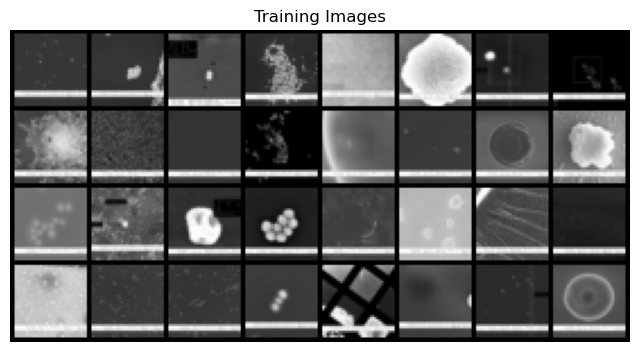

In [6]:
# 绘制部分我们的输入图像
real_batch = next(iter(data_loader))
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis("off")
ax.set_title("Training Images")
ax.imshow(
    vutils.make_grid(
        real_batch[0].to(device)[:64], padding=2, normalize=True
    ).permute(1, 2, 0).cpu()
)
plt.show()

In [7]:
# 标准GAN生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(in_features, out_features, normalize=True):
            layers = [nn.Linear(in_features, out_features)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
        
    def forward(self, z):
        img = self.model(z)     # 输入形状为(batch_size, latent_dim)
        img = img.reshape(img.shape[0], *img_shape)  # 输出形状为(batch_size, channels, img_size, img_size)
        return img

In [8]:
netG = Generator().to(device)
print(netG)

# 写入tensorboard
if sys.platform.startswith('win'):
    writerGpath = r'D:\git_files\neural_network\GAN\run3\Generator'
else:
    writerGpath = r'/home/cxmd/文档/git_files/neural_network/GAN/run3/Generator'

writerG = SummaryWriter(writerGpath)

input_to_netG = torch.randn(batch_size, latent_dim, device=device)
writerG.add_graph(netG, input_to_model=input_to_netG)
writerG.close()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=1024, bias=True)
    (12): Tanh()
  )
)


In [9]:
# 判别器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, img):
        img_flat = img.reshape(img.shape[0], -1)    # 输入形状为(batch_size, channels, img_size, img_size)
        validity = self.model(img_flat)            # 输出形状为(batch_size, 1)
        return validity

In [10]:
netD = Discriminator().to(device)
print(netD)

if sys.platform.startswith("win"):
    writerDpath = r'D:\git_files\neural_network\GAN\run3\Discriminator'
else:
    writerDpath = r'/home/cxmd/文档/git_files/neural_network/GAN/run3/Discriminator'

writerD = SummaryWriter(writerDpath)
input_to_netD = torch.randn(batch_size, int(np.prod(img_shape)), device=device)
writerD.add_graph(netD, input_to_netD)
writerD.close()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [11]:
# 设置损失函数和优化器
adversarial_loss = nn.BCELoss()  # 二值交叉熵 Binary cross entropy loss
optimizer_G = torch.optim.Adam(netG.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=lr, betas=(b1, b2))

In [12]:
# 记录开始训练的时间
start_time = time.time()

batches_done = 0
if sys.platform.startswith('win'):
    writerpath = r'D:\git_files\neural_network\GAN\run3'
else:
    writerpath = r'/home/cxmd/文档/git_files/neural_network/GAN/run3'
writer = SummaryWriter(writerpath)


for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(data_loader):
        # 如果这个批次的样本数量小于批次大小，跳过这个批次
        if imgs.shape[0] != batch_size:
            continue
        
        # 创建真实图像和生成图像的标签
        valid = torch.ones([imgs.size(0), 1]).to(device)
        fake = torch.zeros([imgs.size(0), 1]).to(device)
        
        # 真实输入训练集
        real_imgs = imgs.to(device)
        # real_imgs = Variable(imgs.type(Tensor)).to(device)
        
        # -----------------
        #  训练生成器
        # -----------------
        
        optimizer_G.zero_grad()
        
        # 生成正态分布噪声以作为生成器的输入
        z = torch.randn(imgs.shape[0], latent_dim, device=device)
        
        # 生成器生成的图像
        gen_imgs = netG(z).to(device)
        
        # 生成器损失函数来衡量生成器欺骗判别器的能力
        g_loss = adversarial_loss(netD(gen_imgs), valid).to(device)
        
        g_loss.backward()
        optimizer_G.step()
        
        # ---------------------
        #  训练判别器
        # ---------------------
        
        optimizer_D.zero_grad()
        
        # 判别器损失函数来衡量分辨出真实图片和生成器生成图片的能力
        real_loss = adversarial_loss(netD(real_imgs), valid)
        fake_loss = adversarial_loss(netD(gen_imgs.detach()), fake)
        
        d_loss = (real_loss + fake_loss) / 2
        
        real_score = netD(real_imgs)
        fake_score = netD(gen_imgs.detach())
        
        d_loss.backward()
        optimizer_D.step()
        
        # tensorboard跟踪数据
        writer.add_scalar('loss_g', g_loss.item(), epoch*len(data_loader)+i)
        writer.add_scalar('loss_d', d_loss.item(), epoch*len(data_loader)+i)
        writer.add_scalar('D(x)', real_score.mean().item(), epoch*len(data_loader)+i)
        writer.add_scalar('D(G(z))', fake_score.mean().item(), epoch*len(data_loader)+i)
        
        if (i + 1) % 10 == 0:      # 每一百批次输入一次训练程度
            # 计算过去的时间
            elapsed_time = time.time() - start_time
            print('Elapsed time: {:.4f} seconds, Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(elapsed_time, epoch + 1, n_epochs, i + 1, len(data_loader), d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

        if batches_done % sample_interval == 0:
            # writer image to tensorboard
            imgs_to_tensorboard = gen_imgs.data[:25]
            imgs_to_tensorboard = vutils.make_grid(imgs_to_tensorboard, nrow=5, normalize=True).cpu()
            writer.add_image("fake_imgs", imgs_to_tensorboard, epoch*len(data_loader)+i)
            
            save_image(gen_imgs.data[:25], r"/home/cxmd/文档/git_files/neural_network/GAN/images3/%d.png" % batches_done, nrow=5, normalize=True)

        batches_done += 1
writer.close()

Elapsed time: 2.6055 seconds, Epoch [1/200], Step [10/123], d_loss: 0.5916, g_loss: 0.6634, D(x): 0.64, D(G(z)): 0.52
Elapsed time: 4.2344 seconds, Epoch [1/200], Step [20/123], d_loss: 0.5310, g_loss: 0.6508, D(x): 0.73, D(G(z)): 0.52
Elapsed time: 5.5388 seconds, Epoch [1/200], Step [30/123], d_loss: 0.4938, g_loss: 0.6260, D(x): 0.82, D(G(z)): 0.53
Elapsed time: 6.3884 seconds, Epoch [1/200], Step [40/123], d_loss: 0.5036, g_loss: 0.5907, D(x): 0.83, D(G(z)): 0.55
Elapsed time: 8.2235 seconds, Epoch [1/200], Step [50/123], d_loss: 0.4970, g_loss: 0.5737, D(x): 0.86, D(G(z)): 0.56
Elapsed time: 9.8149 seconds, Epoch [1/200], Step [60/123], d_loss: 0.5008, g_loss: 0.5800, D(x): 0.84, D(G(z)): 0.56
Elapsed time: 11.1164 seconds, Epoch [1/200], Step [70/123], d_loss: 0.4901, g_loss: 0.5885, D(x): 0.85, D(G(z)): 0.56
Elapsed time: 12.5685 seconds, Epoch [1/200], Step [80/123], d_loss: 0.5018, g_loss: 0.5948, D(x): 0.82, D(G(z)): 0.55
Elapsed time: 13.9117 seconds, Epoch [1/200], Step [90